# Seismic Image Classification

### 1. Data loading

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# read npy format data
data = Path(r"C:\Users\에너지자원공학과\Desktop\Python\AI\AI-in-Engenery")
X_syn = np.load(data/'synth_500_proc.npy')
X_fld = np.load(data/'field_500_proc.npy')

# print(X_org.shape, Y_org.shape)
print(X_syn.shape)
print(X_fld.shape)

(500, 128, 128)
(500, 128, 128)


500 — number of samples (individual 2D maps/images) <br>
128 — height (rows) of each map <br>
128 — width (columns) of each map

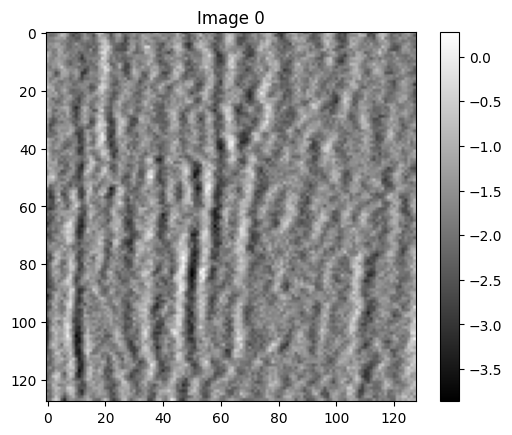

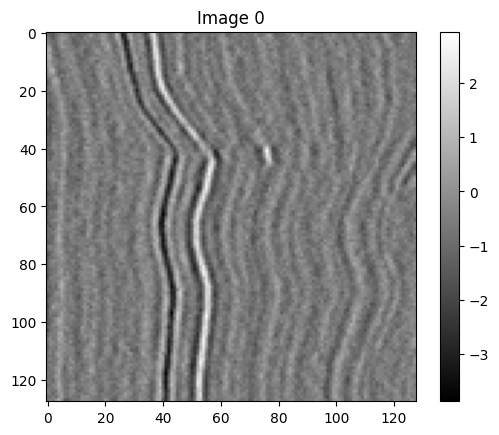

In [13]:
data = np.load("field_500_proc.npy") # shape (500,128,128)
i = 0  # индекс нужной картинки
plt.imshow(data[i], cmap="gray"); plt.colorbar(); plt.title(f"Image {i}"); plt.show()

data = np.load("synth_500_proc.npy") # shape (500,128,128)
i = 0  # индекс нужной картинки
plt.imshow(data[i], cmap="gray"); plt.colorbar(); plt.title(f"Image {i}"); plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_label_comp(data1, data2, image_index): # function visually compare two 2D images at the same index from different arrays

    fig, axes = plt.subplots(1, 2, figsize=(8, 4)) # 1 row, 2 columns

    # 첫 번째 subplot 
    im1 = axes[0].imshow(np.transpose(data1[image_index]), cmap='gray_r', interpolation='none') # 'gray_r'는 흑백 반전 colormap
    axes[0].set_title('seismic image 1')

    # 첫 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider1 = make_axes_locatable(axes[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)

    # 두 번째 subplot
    im2 = axes[1].imshow(np.transpose(data2[image_index]), cmap='gray_r', interpolation='none')
    axes[1].set_title('seismic image 2')

    # 두 번째 subplot에 대한 colorbar (세로 크기 동일)
    divider2 = make_axes_locatable(axes[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)

    plt.tight_layout()
    plt.show()


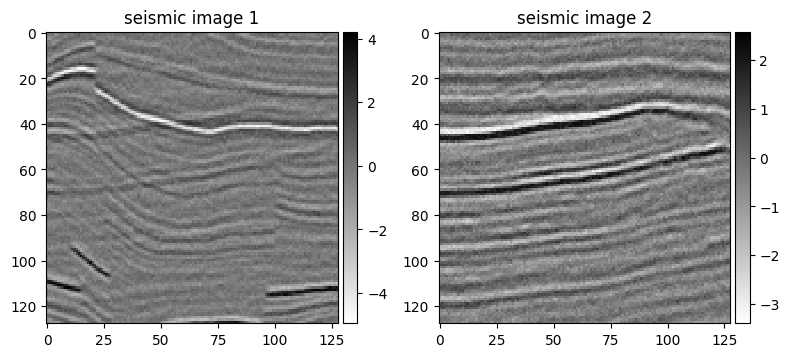

In [ ]:
plot_label_comp(X_syn, X_fld, 250) # compare 250-th image from both datasets

Make labeling


In [18]:
import numpy as np
import tensorflow as tf

# 1) загрузка
X_syn = np.load("synth_500_proc.npy")   # (500, 128, 128)
X_fld = np.load("field_500_proc.npy")   # (500, 128, 128)

# 2) метки: synthetic=0, field=1
y_syn = np.zeros(len(X_syn), dtype=np.int32)
y_fld = np.ones(len(X_fld), dtype=np.int32)

# 3) объединение и приведение типов/канала
X = np.concatenate([X_syn, X_fld], axis=0).astype(np.float32)  # (1000, 128, 128)
y = np.concatenate([y_syn, y_fld], axis=0)                     # (1000,)
X = X[..., None]                                               # (1000, 128, 128, 1)

# (опционально) нормализация
mean, std = X.mean(), X.std()
X = (X - mean) / (std + 1e-8)

# 4) перемешивание и разбиение (всё на NumPy)
perm = np.random.default_rng(42).permutation(len(X))
X, y = X[perm], y[perm]

n = len(X)
n_train = int(0.7 * n)
n_val = int(0.15 * n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
X_test,  y_test  = X[n_train + n_val:], y[n_train + n_val:]

# 5) tf.data пайплайны
def make_ds(X, y, batch=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train)
val_ds   = make_ds(X_val, y_val, shuffle=False)
test_ds  = make_ds(X_test, y_test, shuffle=False)

print("Shapes:", X.shape, y.shape)
print("Class mapping: 0 -> synthetic, 1 -> field")
for imgs, labels in train_ds.take(1):
    print("Batch:", imgs.shape, labels.numpy()[:8])


Shapes: (1000, 128, 128, 1) (1000,)
Class mapping: 0 -> synthetic, 1 -> field
Batch: (32, 128, 128, 1) [1 1 1 1 1 1 1 1]
